# Usable Data Map (UDM2) Cloud Detection

In this guide, you'll learn about Planet's automatic detection of pixels which are cloudy or otherwise obscured, so that you can make more intelligent choices about whether the data meets your needs.

In 2018, Planet undertook a project to improve cloud detection, and this guide will focus on the improved metadata that can be used for filtering and the new `ortho_udm2` asset that provides access to detail classification of every pixel. This new information will be available for all `PSScene` and `PSOrthoTile` items created after 2018-08-01 and for some items before this date (note that a very small number of items created after this date are without the `ortho_udm2` asset). Planet is not currently planning on removing old cloud cover metadata or the old `udm` asset.

### Full specification

The full specification for the `ortho_udm2` asset and the related metadata fields can be found in the [UDM 2](https://developers.planet.com/docs/api/udm-2/) section of the API documentation.

## Finding clear imagery

One of the benefits of accurate and automated cloud detection is that it allows users to filter out images that don't meet a certain quality threshold. Planet's Data API allows users to [search](https://developers.planet.com/docs/api/searches-filtering/) based on the value of the imagery metadata.

For example, if you are using the Planet command-line tool, you can search for all four-band PlanetScope scenes that have less than 10% cloud cover in them with the following:

    planet data search --item-type PSScene --range cloud_percent lt 10 --asset-type ortho_analytic_4b,ortho_udm2 
    
Planet's cloud detection algorithm classifies every pixel into one of six different categories, each of which has a corresponding metadata field that reflects the percentage of data that falls into the category.

| Class | Metadata field |
| --- | --- |
| clear | `clear_percent` |
| snow | `snow_ice_percent` |
| shadow | `shadow_percent` |
| light haze | `light_haze_percent` |
| heavy haze| `heavy_haze_percent` |
| cloud | `cloud_percent` |

These can be combined to refine search results even further. An example of searching for imagery that has less than 10% clouds and less than 10% heavy haze:

    planet data search --item-type PSScene --range cloud_percent lt 10 --range heavy_haze_percent lt 10 
    --asset-type ortho_analytic_4b,ortho_udm2
    
Every pixel will be classified into only one of the categories above; a pixel may be snowy or obscured by a shadow but it can not be both at the same time!

The following example will show how to do a search for imagery that is at least 90% clear using Planet's Python client.

In [13]:
from planet import api
import time
import os
import rasterio
from rasterio.plot import show
client = api.ClientV1()

In [4]:
# build a filter for the AOI
filter = api.filters.range_filter("clear_percent", gte=90)

# show the structure of the filter
print(filter)

{'field_name': 'clear_percent', 'type': 'RangeFilter', 'config': {'gte': 90}}


In [5]:
# we are requesting PlanetScope 4 Band imagery
item_types = ['PSScene']
request = api.filters.build_search_request(filter, item_types)

# this will cause an exception if there are any API related errors
results = client.quick_search(request)

In [6]:
# print out the ID of the most recent 10 images that matched
for item in results.items_iter(10):
    print('%s' % item['id'])

20220403_084057_86_2435
20220403_084046_37_2435
20220403_084037_17_2435
20220403_084027_98_2435
20220403_084023_39_2435
20220403_083937_43_2435
20220403_083916_75_2435
20220403_084107_05_2435
20220403_084102_45_2435
20220403_083955_81_2435


## The `udm2` asset

In addition to metadata for filtering, the `ortho_udm2` asset provides a pixel-by-pixel map that identifies the classification of each pixel.

In the example below, cloudy pixels are highlighted in yellow, shadows in red and light haze in blue.

| Original image | `udm2` overlay |
| :--- | :--- |
| ![20190228_172942_0f1a_3B_Visual.tif](assets/20190228_172942_0f1a_orig.png) |  ![Detected clouds](assets/20190228_172942_0f1a_map.png) |
| `20190228_172942_0f1a_3B_Visual.tif` | `20190228_172942_0f1a_udm2.tif` |

The `udm2` structure is to use a separate band for each classification type. Band 2, for example, indicates that a pixel is snowy when its value is 1, band 3 indicates shadow and so on. 

The following Python will download the data above and then display pixels that fall into a certain classifications.

In [7]:
item_type = "PSScene"
item_id = "20190228_172942_0f1a"

In [10]:
# activate assets
assets = client.get_assets_by_id("PSScene", item_id).get()
client.activate(assets["ortho_analytic_4b"])
client.activate(assets["ortho_udm2"])

# wait until activation completes
while True:
    assets = client.get_assets_by_id("PSScene", item_id).get()
    if "location" in assets["ortho_analytic_4b"] and "location" in assets["ortho_udm2"]:
        print('assets activated')
        break
    time.sleep(10)    

assets activated


In [11]:
# start downloads
data_dir = 'data'
r1 = client.download(assets["ortho_analytic_4b"], callback=api.write_to_file(data_dir))
r2 = client.download(assets["ortho_udm2"], callback=api.write_to_file(data_dir))

In [14]:
# wait until downloads complete
r1.wait()
r2.wait()
img_file = os.path.join(data_dir, r1.get_body().name)
udm_file = os.path.join(data_dir, r2.get_body().name)
print("image: {}".format(img_file))
print("udm2:  {}".format(udm_file))

image: data/20190228_172942_0f1a_3B_AnalyticMS.tif
udm2:  data/20190228_172942_0f1a_3B_udm2.tif


In [30]:
with rasterio.open(udm_file) as src:
    shadow_mask = src.read(3).astype(bool)
    cloud_mask = src.read(6).astype(bool)

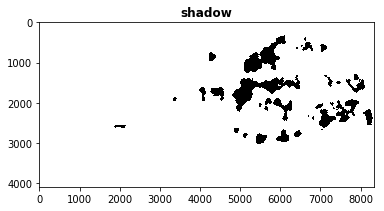

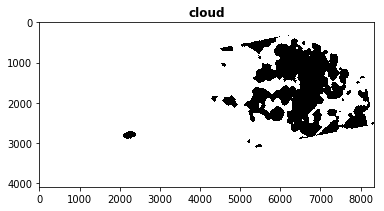

In [32]:
show(shadow_mask, title="shadow", cmap="binary")
show(cloud_mask, title="cloud", cmap="binary")

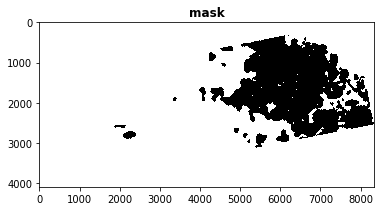

In [33]:
mask = shadow_mask + cloud_mask
show(mask, title="mask", cmap="binary")

In [34]:
with rasterio.open(img_file) as src:
    profile = src.profile
    img_data = src.read([3, 2, 1], masked=True) / 10000.0 # apply RGB ordering and scale down

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


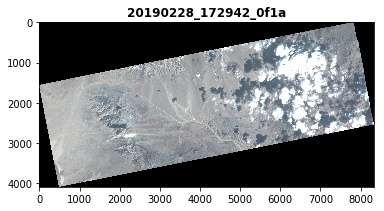

In [35]:
show(img_data, title=item_id)

In [36]:
img_data.mask = mask
img_data = img_data.filled(fill_value=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


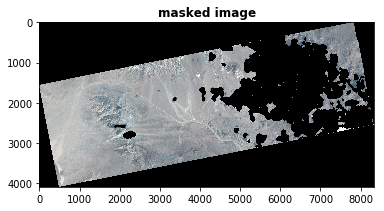

In [37]:
show(img_data, title="masked image")

The image stored in `img_data` now has cloudy pixels masked out and can be saved or used for analysis.